# Imports

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import torch.nn.functional as F
import numpy as np
import os
import random
import sys

# Siamese Network

## Data

In [22]:
import os

input_path = '../input/lfw-siamese'
output_path = '../working'
directory_name = input_path+'/lfw'
zip_file_name = input_path+'/lfw.zip'

if not os.path.exists(directory_name):
    print(f"Unzipping {zip_file_name}...")
    !unzip {zip_file_name} -d {directory_name}
else:
    print(f"The directory '{directory_name}' already exists. No need to unzip.")

The directory '../input/lfw-siamese/lfw' already exists. No need to unzip.


## Dataset, DataLoader and Data Augmentation

In [23]:
N=16
class custom_dset(Dataset):
    def __init__(self,
                 img_path,
                 txt_path,
                 img_transform1,
                 img_transform2,
                 ):
        with open(txt_path, 'r') as f:
            lines = f.readlines()
            self.img1_list = [
                os.path.join(img_path, i.split()[0]) for i in lines
            ]
            self.img2_list = [
                os.path.join(img_path, i.split()[1]) for i in lines
            ]
            self.label_list = [i.split()[2] for i in lines]
        self.img_transform1 = img_transform1
        self.img_transform2 = img_transform2
    def __getitem__(self, index):
        img1_path = self.img1_list[index]
        img2_path = self.img2_list[index]
        label = self.label_list[index]
        label=int(label)
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        img1 = (img1/255.0).astype(np.float32)
        img2 = (img2/255.0).astype(np.float32)
        img1 = cv2.resize(img1,(128,128), interpolation = cv2.INTER_AREA)
        img2 = cv2.resize(img2,(128,128), interpolation = cv2.INTER_AREA)
        img1 = self.img_transform1(img1)
        img2 = self.img_transform2(img2)
        return img1,img2,label
    def __len__(self):
        return len(self.label_list)

class Rescale(object):
    def __call__(self, img):
        if random.random()<0.7:
            f = round(0.1*random.randint(7, 13),2)
            if f>1:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_CUBIC)
                a = int(round((f*128-128)/2))
                img = img[a:a+128,a:a+128]
            else:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_AREA)
                a= int(round((128-f*128)/2))
                temp=np.zeros([128,128,3],dtype=np.uint8)
                temp.fill(0)
                for i in range(img.shape[0]):
                    for j in range(img.shape[1]):
                        temp[i+a,j+a]=img[i,j]
                img=temp
        return img

class Flip(object):
    def __call__(self,img):
        if random.random()<0.7:
            return cv2.flip(img,1)
        return img

class Rotate(object):
    def __call__(self,img):
        if random.random()<0.7:
            angle=random.random()*60-30
            rows,cols,cn = img.shape
            M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
            img = cv2.warpAffine(img,M,(cols,rows))
            return img
        return img

class Translate(object):
    def __call__(self,img):
        if random.random()<0.7:
            x=random.random()*20-10
            y=random.random()*20-10
            rows,cols,cn = img.shape
            M= np.float32([[1,0,x],[0,1,y]])
            img = cv2.warpAffine(img,M,(cols,rows))
        return img

transform1 = transforms.Compose([Rescale(),Flip(),Translate(),Rotate(),transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform2 = transforms.Compose([Rescale(),Flip(),Translate(),Rotate(),transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = custom_dset(input_path+'/lfw', input_path+'/train.txt',transform1,transform2)
train_loader = DataLoader(train_set, batch_size=N, shuffle=True, num_workers=2)

## Contrastive Loss

### Model, Optmizer and Loss Function


In [25]:
lr = 1e-6
num_epoches = 100
dimension_latent_space = 1024

class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            )
        self.conv4 =nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            )
        self.fc = nn.Sequential(
            nn.Linear(131072, dimension_latent_space),
            nn.ReLU(),
            nn.BatchNorm1d(dimension_latent_space),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net=Cnn()
if torch.cuda.is_available() :
    net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

loss_func = ContrastiveLoss()
l_his=[]

weigth_contrastive = "weigth_contrastive"+str(dimension_latent_space)
path_contrastive = output_path+"/"+weigth_contrastive

### Train

Epoch: 1 Training...
[1,   100] loss: 950.870
Epoch: 2 Training...
[2,   100] loss: 946.508
Epoch: 3 Training...
[3,   100] loss: 920.198
Epoch: 4 Training...
[4,   100] loss: 853.246
Epoch: 5 Training...
[5,   100] loss: 793.060
Epoch: 6 Training...
[6,   100] loss: 708.328
Epoch: 7 Training...
[7,   100] loss: 633.637
Epoch: 8 Training...
[8,   100] loss: 616.600
Epoch: 9 Training...
[9,   100] loss: 584.684
Epoch: 10 Training...
[10,   100] loss: 569.822
Epoch: 11 Training...
[11,   100] loss: 515.928
Epoch: 12 Training...
[12,   100] loss: 487.775
Epoch: 13 Training...
[13,   100] loss: 447.318
Epoch: 14 Training...
[14,   100] loss: 432.496
Epoch: 15 Training...
[15,   100] loss: 391.558
Epoch: 16 Training...
[16,   100] loss: 379.974
Epoch: 17 Training...
[17,   100] loss: 351.876
Epoch: 18 Training...
[18,   100] loss: 324.597
Epoch: 19 Training...
[19,   100] loss: 294.643
Epoch: 20 Training...
[20,   100] loss: 264.092
Epoch: 21 Training...
[21,   100] loss: 265.281
Epoch: 22 

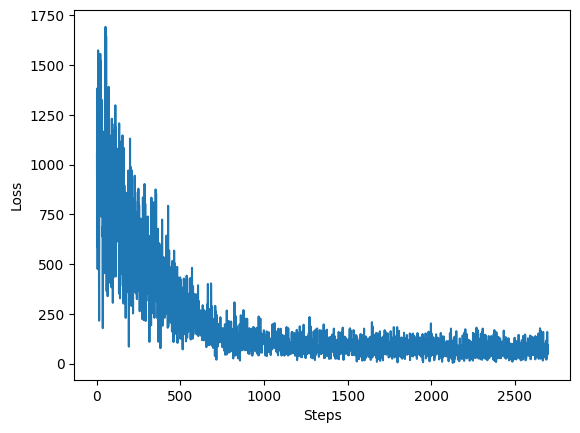

In [26]:
if not os.path.exists(path_contrastive): # Train iff the weigths files does not exist
    for epoch in range(num_epoches):
        print('Epoch:', epoch + 1, 'Training...')
        running_loss = 0.0
        for i,data in enumerate(train_loader, 0):
            image1s,image2s,labels=data
            if torch.cuda.is_available():
                image1s = image1s.cuda()
                image2s = image2s.cuda()
                labels = labels.cuda()
            image1s, image2s, labels = Variable(image1s), Variable(image2s), Variable(labels.float())
            optimizer.zero_grad()
            f1=net(image1s)
            f2=net(image2s)
            loss = loss_func(f1,f2,labels)
            loss.backward()
            optimizer.step()
            if i % 5 == 4:
                l_his.append(loss.item())
            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
    print('Finished Training')
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(l_his)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    torch.save(net.state_dict(), weigth_contrastive)

## Working in Latent Space

### Generating Data

In [27]:
name_train_latent = f"train_latent_{dimension_latent_space}.csv"
path_train_latent = output_path+"/"+name_train_latent

name_test_latent = f"test_latent_{dimension_latent_space}.csv"
path_test_latent = output_path+"/"+name_test_latent

train_latent, test_latent = [], []
if not os.path.exists(path_train_latent):
    net.load_state_dict(torch.load(path_contrastive, weights_only=True))
    transform = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    test_set = custom_dset(input_path+'/lfw', input_path+'/train.txt',transform,transform)
    test_loader = DataLoader(test_set, batch_size=N, shuffle=True, num_workers=2)
    for data in test_loader:
      image1s,image2s,labels = data
      if torch.cuda.is_available():
        image1s = image1s.cuda()
        image2s = image2s.cuda()
        labels = labels.cuda()
      image1s, image2s, labels = Variable(image1s), Variable(image2s), Variable(labels.float())
      f1=net(image1s)
      f2=net(image2s)
      labels = labels.cpu().data.numpy()
      for i in range(labels.shape[0]):
        train_latent.append(torch.cat((f1[i], f2[i]), dim=0).cpu().detach().numpy())
        train_latent[-1] = np.concatenate((train_latent[-1], np.array([labels[i]])), axis=None)
    train_latent = np.array(train_latent)
    np.savetxt(name_train_latent, train_latent, delimiter=',')

    test_set = custom_dset(input_path+'/lfw', input_path+'/test.txt',transform,transform)
    test_loader = DataLoader(test_set, batch_size=N, shuffle=True, num_workers=2)
    for data in test_loader:
      image1s,image2s,labels = data
      if torch.cuda.is_available():
        image1s = image1s.cuda()
        image2s = image2s.cuda()
        labels = labels.cuda()
      image1s, image2s, labels = Variable(image1s), Variable(image2s), Variable(labels.float())
      f1=net(image1s)
      f2=net(image2s)
      labels = labels.cpu().data.numpy()
      for i in range(labels.shape[0]):
        test_latent.append(torch.cat((f1[i], f2[i]), dim=0).cpu().detach().numpy())
        test_latent[-1] = np.concatenate((test_latent[-1], np.array([labels[i]])), axis=None)
    test_latent = np.array(test_latent)
    np.savetxt(name_test_latent, test_latent, delimiter=',')
else:
    train_latent = np.genfromtxt(path_train_latent, delimiter=',')
    test_latent = np.genfromtxt(path_test_latent, delimiter=',')
    
train_latent.shape, test_latent.shape

((2200, 2049), (1000, 2049))

### Preparing Data For Train

In [30]:
X_train_ = train_latent[:, :-1]
y_train = train_latent[:, -1]
X_test_ = test_latent[:, :-1]
y_test = test_latent[:, -1]
X_train_.shape, y_train.shape, X_test_.shape, y_test.shape

((2200, 2048), (2200,), (1000, 2048), (1000,))

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

### Euclidian Distance

In [9]:
dists0_train = []
dists1_train = []
for i, pattern in enumerate(X_train):
    l1, l2 = torch.Tensor(pattern[:dimension_latent_space]), torch.Tensor(pattern[dimension_latent_space:])
    if y_train[i] == 0:
        dists0_train.append(F.pairwise_distance(l1, l2))
    else:
        dists1_train.append(F.pairwise_distance(l1, l2))
dists0_train = np.array(dists0_train)
dists1_train = np.array(dists1_train)


dists0_test = []
dists1_test = []
for i, pattern in enumerate(X_test):
    l1, l2 = torch.Tensor(pattern[:dimension_latent_space]), torch.Tensor(pattern[dimension_latent_space:])
    if y_test[i] == 0:
        dists0_test.append(F.pairwise_distance(l1, l2))
    else:
        dists1_test.append(F.pairwise_distance(l1, l2))
dists0_test = np.array(dists0_test)
dists1_test = np.array(dists1_test)

tresholds = np.linspace(0, np.sqrt(dimension_latent_space))
for treshold in tresholds:
    acc_train = (np.sum(dists1_train <= treshold) + np.sum(dists0_train > treshold))/X_train.shape[0]
    acc_test = (np.sum(dists1_test <= treshold) + np.sum(dists0_test > treshold))/X_test.shape[0]
    print(f"Treshold = {treshold}: TRAIN = {acc_train*100:.2f}%, TEST = {acc_test*100:.2f}%")

Treshold = 0.0: TRAIN = 50.00%, TEST = 50.00%
Treshold = 0.6530612244897959: TRAIN = 50.00%, TEST = 50.00%
Treshold = 1.3061224489795917: TRAIN = 50.00%, TEST = 50.00%
Treshold = 1.9591836734693877: TRAIN = 50.00%, TEST = 50.00%
Treshold = 2.6122448979591835: TRAIN = 50.00%, TEST = 50.00%
Treshold = 3.265306122448979: TRAIN = 50.00%, TEST = 50.00%
Treshold = 3.9183673469387754: TRAIN = 50.09%, TEST = 50.00%
Treshold = 4.571428571428571: TRAIN = 50.14%, TEST = 50.00%
Treshold = 5.224489795918367: TRAIN = 50.27%, TEST = 50.10%
Treshold = 5.877551020408163: TRAIN = 50.36%, TEST = 50.10%
Treshold = 6.530612244897958: TRAIN = 50.50%, TEST = 50.60%
Treshold = 7.183673469387754: TRAIN = 51.27%, TEST = 51.60%
Treshold = 7.836734693877551: TRAIN = 52.00%, TEST = 52.80%
Treshold = 8.489795918367346: TRAIN = 53.05%, TEST = 53.30%
Treshold = 9.142857142857142: TRAIN = 54.32%, TEST = 54.40%
Treshold = 9.795918367346937: TRAIN = 55.55%, TEST = 55.60%
Treshold = 10.448979591836734: TRAIN = 56.64%, TE

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-4, 4, 10)}
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters:  {'C': 0.005994842503189409}
Best cross-validation score:  0.5549999999999999


In [11]:
logreg_model = LogisticRegression(**grid_search.best_params_)
logreg_model.fit(X_train, y_train)

LogisticRegression(C=0.005994842503189409)

In [12]:
from sklearn.metrics import accuracy_score
print('Train accuracy:', accuracy_score(y_train, logreg_model.predict(X_train)))
print('Val accuracy:', accuracy_score(y_test, logreg_model.predict(X_test)))

Train accuracy: 0.7854545454545454
Val accuracy: 0.534


### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=5)
rf_random_search.fit(X_train, y_train)

print("Best parameters: ", rf_random_search.best_params_)
print("Best cross-validation score: ", rf_random_search.best_score_)

Best parameters:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Best cross-validation score:  0.6495454545454544


In [14]:
rf_model = RandomForestClassifier(**rf_random_search.best_params_)
rf_model.fit(X_train, y_train)

print('Train accuracy:', accuracy_score(y_train, rf_model.predict(X_train)))
print('Val accuracy:', accuracy_score(y_test, rf_model.predict(X_test)))

Train accuracy: 0.9831818181818182
Val accuracy: 0.632


### Neural Network

In [15]:
import keras_tuner as kt
import keras

def build_model(hp):
    model = keras.Sequential()

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=32,
                                                max_value=512,
                                                step=32),
                                   activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld4')

tuner.search_space_summary()

tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 3 Complete [00h 00m 39s]
val_accuracy: 0.6236666639645895

Best val_accuracy So Far: 0.6356666684150696
Total elapsed time: 00h 01m 56s
Results summary
Results in my_dir/helloworld4
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 512
learning_rate: 0.0001
units_1: 352
units_2: 288
Score: 0.6356666684150696

Trial 0 summary
Hyperparameters:
num_layers: 3
units_0: 256
learning_rate: 0.001
units_1: 32
units_2: 32
Score: 0.6313333511352539

Trial 2 summary
Hyperparameters:
num_layers: 3
units_0: 96
learning_rate: 0.01
units_1: 64
units_2: 512
Score: 0.6236666639645895


In [16]:
best_hp = tuner.get_best_hyperparameters()[0]
nn_model = tuner.hypermodel.build(best_hp)
nn_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))
nn_model.summary()

Epoch 1/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5860 - loss: 0.6778 - val_accuracy: 0.5850 - val_loss: 0.6712
Epoch 2/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7304 - loss: 0.5318 - val_accuracy: 0.6050 - val_loss: 0.6685
Epoch 3/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7940 - loss: 0.4791 - val_accuracy: 0.6170 - val_loss: 0.6876
Epoch 4/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8105 - loss: 0.4307 - val_accuracy: 0.6170 - val_loss: 0.6869
Epoch 5/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8378 - loss: 0.3953 - val_accuracy: 0.6160 - val_loss: 0.7199
Epoch 6/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.3479 - val_accuracy: 0.6060 - val_loss: 0.7501
Epoch 7/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.3008 - val_accuracy: 0.6180 - val_loss: 0.8186
Epoch 8/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.2634 - val_accuracy: 0.6280 - val_loss

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 352)            │       180,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 288)            │       101,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,994,853 (15.24 MB)

 Trainable params: 1,331,617 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,663,236 (10.16 MB)

## BCE

### Model, Optmizer and Loss Function

In [18]:
lr = 1e-5
num_epoches = 30
dimension_latent_space = 64

class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            )
        self.conv4 =nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            )
        self.fc1 = nn.Sequential(
            nn.Linear(131072, dimension_latent_space),
            nn.ReLU(),
            nn.BatchNorm1d(dimension_latent_space),
        )
        self.fc2 = nn.Sequential(
                nn.Linear(2*dimension_latent_space, 1),
                nn.Sigmoid(),
                )
    def forward(self,x,y):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        y = self.conv1(y)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.conv4(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)

        f = torch.cat((x,y),1)
        f = self.fc2(f)
        return f

net=Cnn()

if torch.cuda.is_available() :
    net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr)
loss_func = nn.BCELoss()
l_his=[]

weigth_bce = "weigth_bce"+str(dimension_latent_space)
path_bce = output_path+"/"+weigth_bce

### Train

Epoch: 1 Training...
[1,   100] loss: 0.724
Epoch: 2 Training...
[2,   100] loss: 0.695
Epoch: 3 Training...
[3,   100] loss: 0.684
Epoch: 4 Training...
[4,   100] loss: 0.683
Epoch: 5 Training...
[5,   100] loss: 0.682
Epoch: 6 Training...
[6,   100] loss: 0.680
Epoch: 7 Training...
[7,   100] loss: 0.683
Epoch: 8 Training...
[8,   100] loss: 0.679
Epoch: 9 Training...
[9,   100] loss: 0.678
Epoch: 10 Training...
[10,   100] loss: 0.677
Epoch: 11 Training...
[11,   100] loss: 0.668
Epoch: 12 Training...
[12,   100] loss: 0.674
Epoch: 13 Training...
[13,   100] loss: 0.663
Epoch: 14 Training...
[14,   100] loss: 0.667
Epoch: 15 Training...
[15,   100] loss: 0.653
Epoch: 16 Training...
[16,   100] loss: 0.660
Epoch: 17 Training...
[17,   100] loss: 0.670
Epoch: 18 Training...
[18,   100] loss: 0.660
Epoch: 19 Training...
[19,   100] loss: 0.654
Epoch: 20 Training...
[20,   100] loss: 0.655
Epoch: 21 Training...
[21,   100] loss: 0.645
Epoch: 22 Training...
[22,   100] loss: 0.649
Epoch:

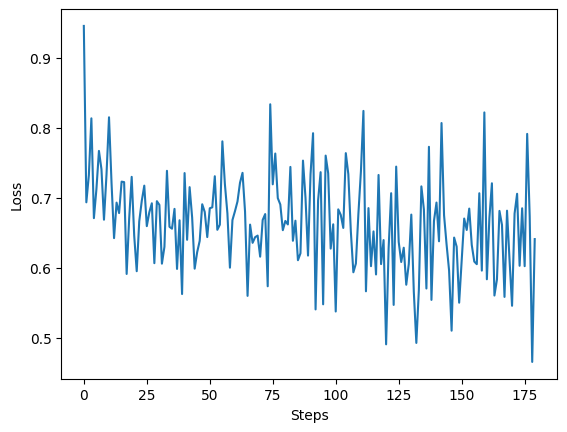

In [19]:
if not os.path.exists(path_bce): # Train iff the weigths files does not exist
    for epoch in range(num_epoches):
        print('Epoch:', epoch + 1, 'Training...')
        running_loss = 0.0
        for i,data in enumerate(train_loader, 0):
            image1s,image2s,labels=data
            if torch.cuda.is_available():
                image1s = image1s.cuda()
                image2s = image2s.cuda()
                labels = labels.cuda()
            image1s, image2s, labels = Variable(image1s), Variable(image2s), Variable(labels.float())
            optimizer.zero_grad()
            f=net(image1s,image2s).squeeze()
            loss = loss_func(f,labels)
            loss.backward()
            optimizer.step()
            if i % 20 == 19:
                l_his.append(loss.item())
            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
    print('Finished Training')
    torch.save(net.state_dict(), weigth_bce)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(l_his)
    plt.xlabel('Steps')
    plt.ylabel('Loss')

### Test

In [20]:
net.load_state_dict(torch.load(path_bce, weights_only=True))

#test data
transform = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


tresholds = np.linspace(0.001, 1)
for treshold in tresholds:
    print(f"Treshold = {treshold}")

    test_set = custom_dset(input_path+'/lfw', input_path+'/train.txt',transform,transform)
    test_loader = DataLoader(test_set, batch_size=N, shuffle=False, num_workers=2)
    
    correct = 0
    total = 0
    for i,data in enumerate(test_loader,0):
        image1s,image2s,labels = data
        if torch.cuda.is_available():
            image1s = image1s.cuda()
            image2s = image2s.cuda()
            labels = labels.cuda()
        image1s, image2s, labels = Variable(image1s), Variable(image2s), Variable(labels.float())
       # print(labels)
        outputs = net(image1s,image2s)
        outputs = outputs.cpu()
        for j in range(outputs.size()[0]):
            if ((outputs.data.numpy()[j]<treshold)):
                if labels.data.cpu().numpy()[j]==0:
                    correct +=1
                    total+=1
                else:
                    total+=1
            else:
                if labels.data.cpu().numpy()[j]==1:
                    correct +=1
                    total+=1
                else:
                    total+=1

    print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

    test_set = custom_dset(input_path+'/lfw', input_path+'/test.txt',transform,transform)
    test_loader = DataLoader(test_set, batch_size=N, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    for i,data in enumerate(test_loader,0):
        image1s,image2s,labels = data
        if torch.cuda.is_available():
            image1s = image1s.cuda()
            image2s = image2s.cuda()
            labels = labels.cuda()
        image1s, image2s, labels = Variable(image1s), Variable(image2s), Variable(labels.float())
       # print(labels)
        outputs = net(image1s,image2s)
        outputs = outputs.cpu()
        for j in range(outputs.size()[0]):
            if ((outputs.data.numpy()[j]<treshold)):
                if labels.data.cpu().numpy()[j]==0:
                    correct +=1
                    total+=1
                else:
                    total+=1
            else:
                if labels.data.cpu().numpy()[j]==1:
                    correct +=1
                    total+=1
                else:
                    total+=1

    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Treshold = 0.001
Accuracy of the network on the train images: 50 %
Accuracy of the network on the test images: 50 %
Treshold = 0.021387755102040818
Accuracy of the network on the train images: 50 %
Accuracy of the network on the test images: 50 %
Treshold = 0.041775510204081635
Accuracy of the network on the train images: 50 %
Accuracy of the network on the test images: 50 %
Treshold = 0.062163265306122456
Accuracy of the network on the train images: 50 %
Accuracy of the network on the test images: 50 %
Treshold = 0.08255102040816327
Accuracy of the network on the train images: 50 %
Accuracy of the network on the test images: 50 %
Treshold = 0.10293877551020408
Accuracy of the network on the train images: 50 %
Accuracy of the network on the test images: 50 %
Treshold = 0.12332653061224491
Accuracy of the network on the train images: 51 %
Accuracy of the network on the test images: 50 %
Treshold = 0.1437142857142857
Accuracy of the network on the train images: 52 %
Accuracy of the netwo